***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade xgboost > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


In [4]:
SEED = 19
SUB_NBR = "09"

***

In [5]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import stats
import time
import yaml

import category_encoders as ce
import xgboost as xgb
from tqdm import tqdm
from tsforest.forecast import LightGBMForecaster
import optuna

import sys
sys.path.append("../utils")
from memory import reduce_mem_usage
from metrics import RMSSE, ranked_probability_score, scoring_function, binarize_predictions
from inventory import InventoryDaysPredictor

np.random.seed(SEED)
pd.set_option('display.max_columns', None)

***
## loading data for assessment

In [6]:
if ASSESS:
    dataset = (
        pd.read_parquet(f"{input_path}/train-m2.parquet")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )
    
dataset["nrows"] = dataset.groupby("sku")["ds"].transform("count")
print(dataset.sku.nunique())
print(dataset.query("nrows == 30").sku.nunique())

531832
500404


In [7]:
# just for assessment
dataset = (
    dataset
    .query("nrows == 30")
    .query("ds in ('2021-02-01', '2021-03-02')")
    .reset_index(drop=True)
)
print(dataset.sku.nunique())

# skus to remove on validation
skus_to_remove = dataset.query("inventory_days > 30").sku.unique()
dataset = dataset.query("sku not in @skus_to_remove").reset_index(drop=True)
print(dataset.sku.nunique())

500404
272130


In [8]:
dataset["id_lower"] = dataset["inventory_days"].copy() 
dataset["id_upper"] = dataset["inventory_days"].copy()

idx = dataset.query("inventory_days > 30").index
dataset.loc[idx,"id_lower"] = 30
dataset.loc[idx,"id_upper"] = np.inf

In [9]:
idx0 = dataset.query("ds == '2021-02-01'").index
idx1 = dataset.query("ds == '2021-03-02'").index

dataset.loc[idx0,"fold"] = 0
dataset.loc[idx1,"fold"] = 1

print(dataset.query("fold==0").sku.nunique())
print(dataset.query("fold==0").sku.nunique())

272130
272130


In [10]:
numeric_cols = [
    "current_price",
    "listing_type_classic",
    "listing_type_premium",
    "shipping_logistic_type_fulfillment",
    "shipping_logistic_type_cross_docking",
    "shipping_logistic_type_drop_off",
    "shipping_payment_free_shipping",
    "shipping_payment_paid_shipping",
    "minutes_active",
    "weekday_1",
    "weekday_2",
    "weekday_3",
    "weekday_4",
    "weekday_5",
    "weekday_6",
    "weekday_7",
    "q_mean",
    "q_std",
    "target_stock",   
]
print("number of numeric:", len(numeric_cols))

categs_cols = [
    #"sku",
    "item_domain_id",
    #"item_id",
    #"site_id",
    "product_id",
    #"product_family_id",  
]
print("number of categs", len(categs_cols))

categs_to_encode = [
    #"sku",
    #"item_id",
    #"product_family_id",
]

target = "inventory_days"

input_cols = numeric_cols + categs_cols
print("total feats:", len(input_cols))

number of numeric: 19
number of categs 2
total feats: 21


In [11]:
dataset.loc[:,categs_cols].nunique()

item_domain_id    7553
product_id        6445
dtype: int64

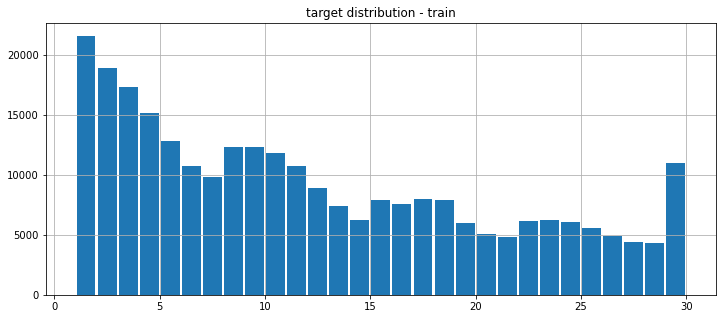

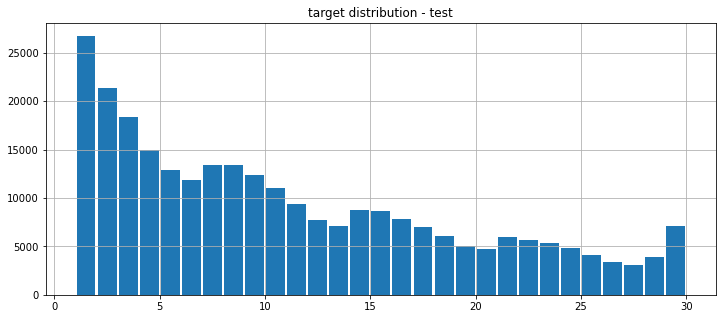

In [12]:
plt.figure(figsize=(12,5))
plt.hist(dataset.query("fold==0")[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - train")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(dataset.query("fold==1")[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - test")
plt.grid()
plt.show()

In [13]:
print("Uncensored rows (train):", len(dataset.query("fold==0").query("inventory_days > 30")) / 1e3)
print("Uncensored rows (valid):", len(dataset.query("fold==1").query("inventory_days > 30")) / 1e3)

Uncensored rows (train): 0.0
Uncensored rows (valid): 0.0


In [14]:
dataset.query("sku not in @skus_to_remove").sku.nunique()

272130

In [15]:
skus_assess_m2 = dataset.query("sku not in @skus_to_remove").sku.unique().tolist()

with open("../data/skus_assess_m2.yaml", "w") as file:
    yaml.dump(skus_assess_m2, file)
    file.close()

***
## model training: assessment

In [16]:
model_params = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    #'aft_loss_distribution': 'normal',
    'aft_loss_distribution': 'logistic',
    #'aft_loss_distribution': 'extreme',
    'aft_loss_distribution_scale': 1.4,
    
    #'tree_method': 'exact',
    #'tree_method': 'approx',
    'tree_method': 'hist',
    'max_bin': 256,
    
    'grow_policy': 'lossguide',
    'max_leaves': 2**6-1,
    'min_child_weight': 50,
    'max_depth': 8,
    
    'learning_rate': 0.05,
    'max_delta_step':.5,
    
    'colsample_bytree':0.8,
    'subsample':0.95,
    
    'lambda':0.1,
    'seed':SEED,
}

------------------------------------------------------------------------------------------
Training model for site: MLA 

Training with fold 0
[0]	valid-aft-nloglik:4.47503
[25]	valid-aft-nloglik:4.19489
[50]	valid-aft-nloglik:3.97659
[75]	valid-aft-nloglik:3.83165
[100]	valid-aft-nloglik:3.75502
[125]	valid-aft-nloglik:3.72799
[150]	valid-aft-nloglik:3.72298
[175]	valid-aft-nloglik:3.72228
[200]	valid-aft-nloglik:3.72227
[225]	valid-aft-nloglik:3.72232
[240]	valid-aft-nloglik:3.72238


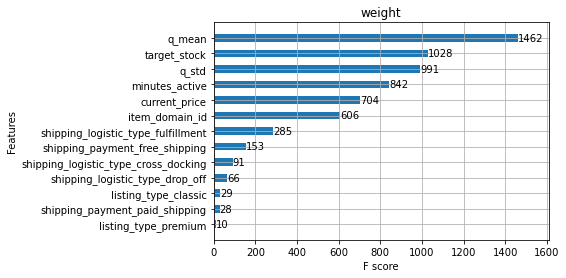

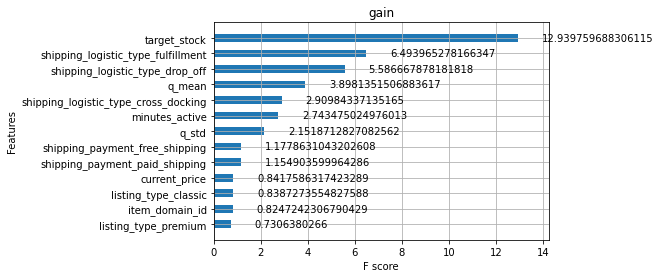

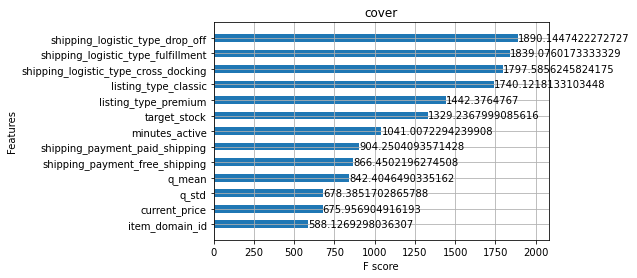

Training with fold 1
[0]	valid-aft-nloglik:4.61380
[25]	valid-aft-nloglik:4.32718
[50]	valid-aft-nloglik:4.10040
[75]	valid-aft-nloglik:3.94578
[100]	valid-aft-nloglik:3.86150
[125]	valid-aft-nloglik:3.83056
[150]	valid-aft-nloglik:3.82351
[175]	valid-aft-nloglik:3.82200
[200]	valid-aft-nloglik:3.82172
[225]	valid-aft-nloglik:3.82146
[250]	valid-aft-nloglik:3.82132
[275]	valid-aft-nloglik:3.82114
[300]	valid-aft-nloglik:3.82118
[325]	valid-aft-nloglik:3.82127
[336]	valid-aft-nloglik:3.82119


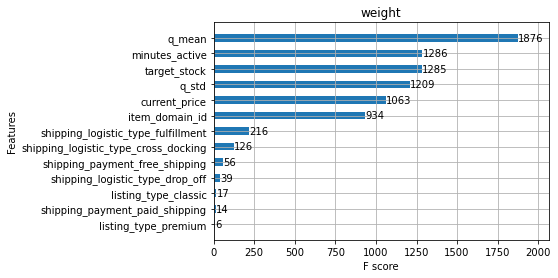

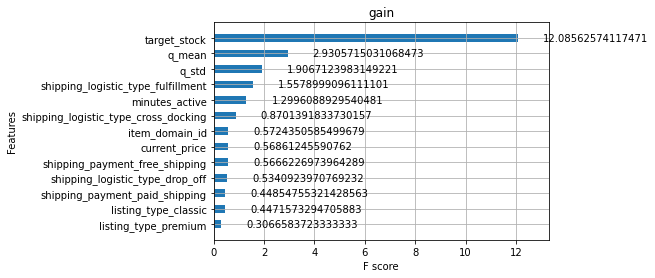

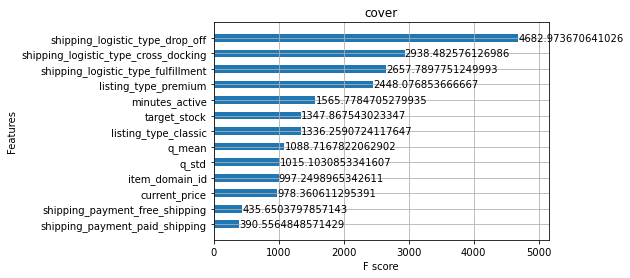

------------------------------------------------------------------------------------------
Training model for site: MLB 

Training with fold 0
[0]	valid-aft-nloglik:4.57953
[25]	valid-aft-nloglik:4.29325
[50]	valid-aft-nloglik:4.06726
[75]	valid-aft-nloglik:3.91343
[100]	valid-aft-nloglik:3.83025
[125]	valid-aft-nloglik:3.79992
[150]	valid-aft-nloglik:3.79367
[175]	valid-aft-nloglik:3.79240
[200]	valid-aft-nloglik:3.79209
[225]	valid-aft-nloglik:3.79195
[250]	valid-aft-nloglik:3.79190
[275]	valid-aft-nloglik:3.79190
[300]	valid-aft-nloglik:3.79190
[325]	valid-aft-nloglik:3.79191
[343]	valid-aft-nloglik:3.79191


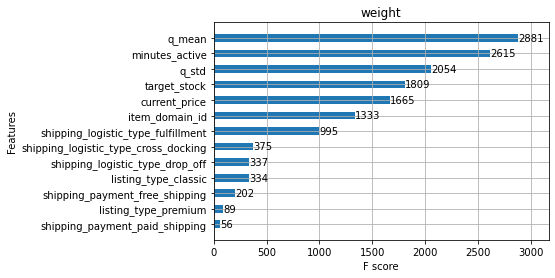

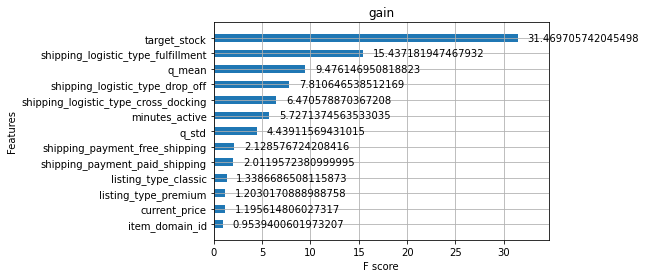

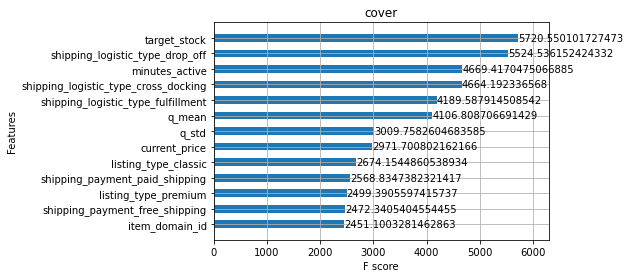

Training with fold 1
[0]	valid-aft-nloglik:4.76002
[25]	valid-aft-nloglik:4.46292
[50]	valid-aft-nloglik:4.22346
[75]	valid-aft-nloglik:4.05485
[100]	valid-aft-nloglik:3.95998
[125]	valid-aft-nloglik:3.92403
[150]	valid-aft-nloglik:3.91549
[175]	valid-aft-nloglik:3.91296
[200]	valid-aft-nloglik:3.91240
[225]	valid-aft-nloglik:3.91224
[250]	valid-aft-nloglik:3.91218
[275]	valid-aft-nloglik:3.91210
[300]	valid-aft-nloglik:3.91209
[325]	valid-aft-nloglik:3.91207
[350]	valid-aft-nloglik:3.91206
[375]	valid-aft-nloglik:3.91210
[399]	valid-aft-nloglik:3.91211


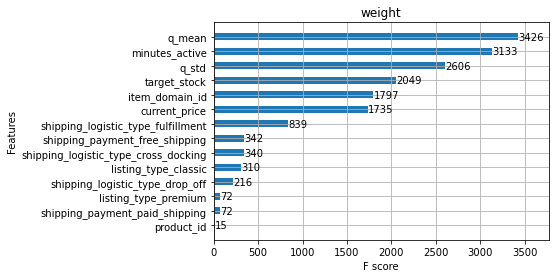

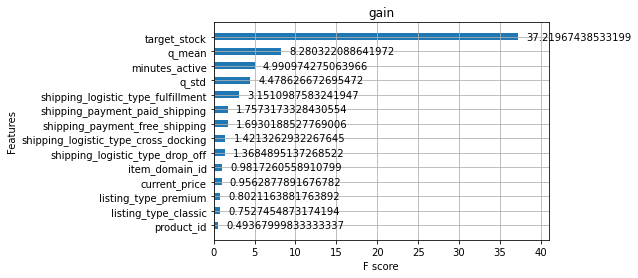

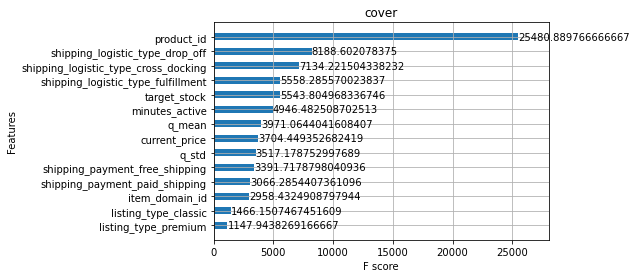

------------------------------------------------------------------------------------------
Training model for site: MLM 

Training with fold 0
[0]	valid-aft-nloglik:4.52822
[25]	valid-aft-nloglik:4.24551
[50]	valid-aft-nloglik:4.02387
[75]	valid-aft-nloglik:3.87460
[100]	valid-aft-nloglik:3.79368
[125]	valid-aft-nloglik:3.76437
[150]	valid-aft-nloglik:3.75864
[175]	valid-aft-nloglik:3.75751
[200]	valid-aft-nloglik:3.75726
[225]	valid-aft-nloglik:3.75720
[250]	valid-aft-nloglik:3.75716
[275]	valid-aft-nloglik:3.75715
[300]	valid-aft-nloglik:3.75716
[325]	valid-aft-nloglik:3.75716
[331]	valid-aft-nloglik:3.75718


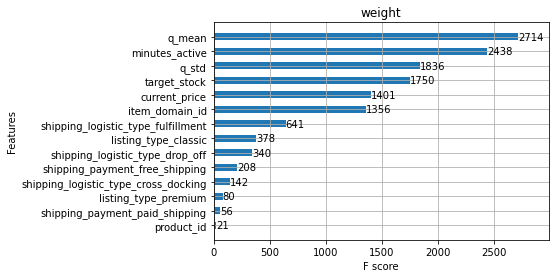

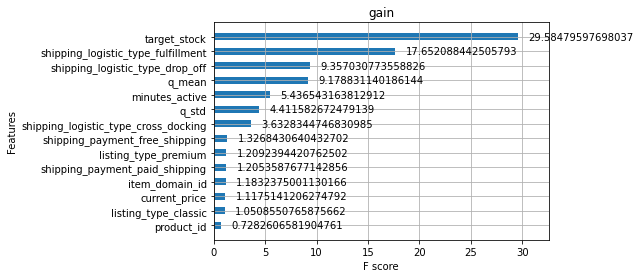

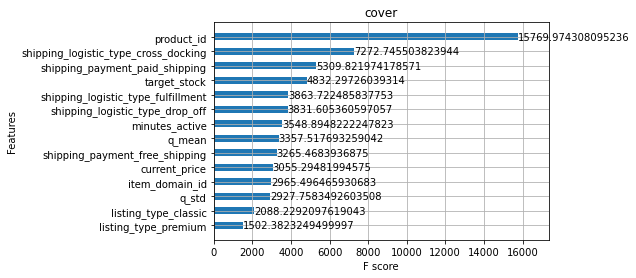

Training with fold 1
[0]	valid-aft-nloglik:4.69062
[25]	valid-aft-nloglik:4.39771
[50]	valid-aft-nloglik:4.16346
[75]	valid-aft-nloglik:4.00066
[100]	valid-aft-nloglik:3.91005
[125]	valid-aft-nloglik:3.87609
[150]	valid-aft-nloglik:3.86826
[175]	valid-aft-nloglik:3.86648
[200]	valid-aft-nloglik:3.86602
[225]	valid-aft-nloglik:3.86586
[250]	valid-aft-nloglik:3.86559
[275]	valid-aft-nloglik:3.86557
[300]	valid-aft-nloglik:3.86554
[325]	valid-aft-nloglik:3.86555
[331]	valid-aft-nloglik:3.86557


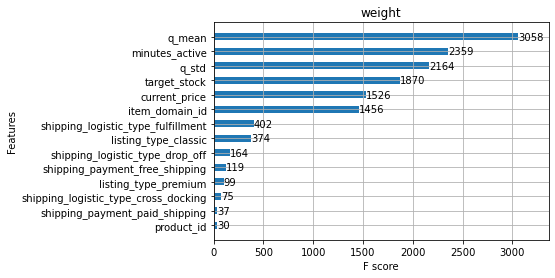

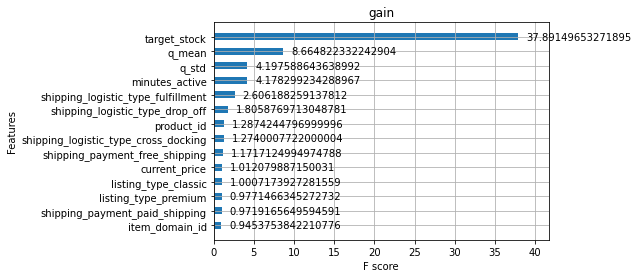

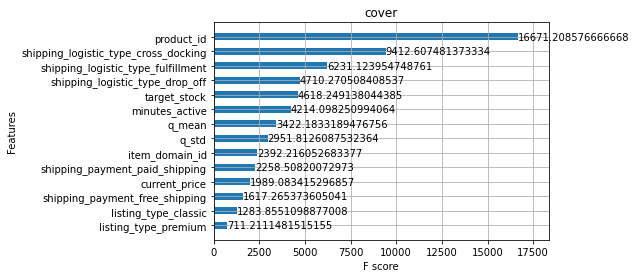

In [17]:
sites = ["MLA","MLB","MLM"]
models_by_site = {"MLA":list(), "MLB":list(), "MLM":list(),}
oof_preds = {"MLA":list(), "MLB":list(), "MLM":list(),}

for site in sites:
    print("-"*90)
    print(f"Training model for site: {site} \n")
    
    for fold in range(2):
        print(f"Training with fold {fold}")
    
        train_dset = (
            dataset
            .query("site_id == @site")
            .query("fold == @fold")
            .reset_index(drop=True)
        )
        valid_dset = (
            dataset
            .query("site_id == @site")
            .query("fold != @fold")
            .reset_index(drop=True)
        )
        
        encoder = ce.CatBoostEncoder()
        train_dset[categs_cols] = encoder.fit_transform(
            train_dset[categs_cols], 
            train_dset.eval("target_stock / inventory_days")
        )
        valid_dset[categs_cols] = encoder.transform(valid_dset[categs_cols])

        # train data matrix
        dtrain = xgb.DMatrix(
            data = train_dset.loc[:, numeric_cols+categs_cols], 
        )
        dtrain.set_float_info('label_lower_bound', train_dset.id_lower.values)
        dtrain.set_float_info('label_upper_bound', train_dset.id_upper.values)
        
        # sample of train data matrix for metric tracking
        sample_index = train_dset.sample(frac=0.25).index
        dtrain_sample = xgb.DMatrix(
            data = train_dset.loc[sample_index, numeric_cols+categs_cols],
        )
        dtrain_sample.set_float_info('label_lower_bound', train_dset.loc[sample_index].id_lower.values)
        dtrain_sample.set_float_info('label_upper_bound', train_dset.loc[sample_index].id_upper.values)

        # valid data matrix
        dvalid = xgb.DMatrix(
            data = valid_dset.loc[:, numeric_cols+categs_cols],
        )
        dvalid.set_float_info('label_lower_bound', valid_dset.id_lower.values)
        dvalid.set_float_info('label_upper_bound', valid_dset.id_upper.values)

        model = xgb.train(
            params = model_params,
            dtrain = dtrain,
            evals = [
                (dvalid,"valid"), 
                #(dtrain_sample,"train_sample")
            ],
            num_boost_round = 5000,
            early_stopping_rounds = 50,
            verbose_eval = 25,
        )

        xgb.plot_importance(model, height=0.5, importance_type="weight", title="weight")
        xgb.plot_importance(model, height=0.5, importance_type="gain", title="gain")
        xgb.plot_importance(model, height=0.5, importance_type="cover", title="cover")
        plt.show()

        valid_dset["pred"] = np.clip(model.predict(dvalid), a_min=None, a_max=30)
        valid_dset = binarize_predictions(valid_dset)
        oof_preds[site].append(valid_dset)
        models_by_site[site].append(model)

In [18]:
for site in sites:
    for fold,(oof,model) in enumerate(zip(oof_preds[site],models_by_site[site])):
        mean_ae = oof.query("sku not in @skus_to_remove").eval("abs(inventory_days - pred)").mean()
        median_ae = oof.query("sku not in @skus_to_remove").eval("abs(inventory_days - pred)").median()
        print(
            site, "-", f"train_fold={fold}", "-",
            f"best_iteration: {model.best_iteration}", "-",
            f"best_score: {model.best_score:0.4f}", "-", 
            f"mean_ae: {mean_ae:0.4f}", "-",
            f"median_ae: {median_ae:0.4f}",
        )
    print()

MLA - train_fold=0 - best_iteration: 190 - best_score: 3.7222 - mean_ae: 4.5073 - median_ae: 3.3078
MLA - train_fold=1 - best_iteration: 286 - best_score: 3.8211 - mean_ae: 5.4784 - median_ae: 3.6942

MLB - train_fold=0 - best_iteration: 293 - best_score: 3.7919 - mean_ae: 4.7883 - median_ae: 3.5167
MLB - train_fold=1 - best_iteration: 349 - best_score: 3.9121 - mean_ae: 5.3313 - median_ae: 3.7724

MLM - train_fold=0 - best_iteration: 282 - best_score: 3.7571 - mean_ae: 4.6992 - median_ae: 3.4172
MLM - train_fold=1 - best_iteration: 282 - best_score: 3.8655 - mean_ae: 5.2186 - median_ae: 3.5788



In [19]:
oof0 = pd.concat([
    oof_preds["MLA"][0][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    oof_preds["MLB"][0][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    oof_preds["MLM"][0][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    ], ignore_index=True
)
oof0["valid_fold"] = oof0["valid_fold"].astype(int)

oof1 = pd.concat([
    oof_preds["MLA"][1][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    oof_preds["MLB"][1][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    oof_preds["MLM"][1][["sku","inventory_days","pred","fold"]].rename({"fold":"valid_fold"}, axis=1),
    ], ignore_index=True
)
oof1["valid_fold"] = oof1["valid_fold"].astype(int)

In [20]:
print("Overall Mean AE on fold1:  ", oof0.eval("abs(inventory_days-pred)").mean())
print("Overall Median AE on fold1:", oof0.eval("abs(inventory_days-pred)").median())

Overall Mean AE on fold1:   4.726693979080135
Overall Median AE on fold1: 3.455824851989746


In [21]:
print("Overall Mean AE on fold0:  ", oof1.eval("abs(inventory_days-pred)").mean())
print("Overall Median AE on fold0:", oof1.eval("abs(inventory_days-pred)").median())

Overall Mean AE on fold0:   5.2978386266585575
Overall Median AE on fold0: 3.6864402294158936


In [23]:
oof_concat = pd.concat([oof0,oof1], ignore_index=True)
oof_concat.to_csv("../results/oof_preds_xgb-m2.csv", index=False)

***
## analysis of OOF predictions

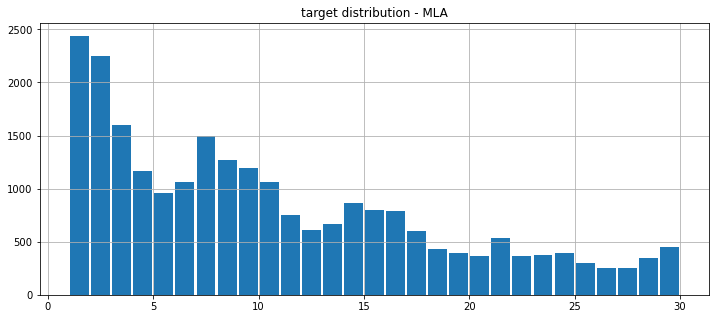

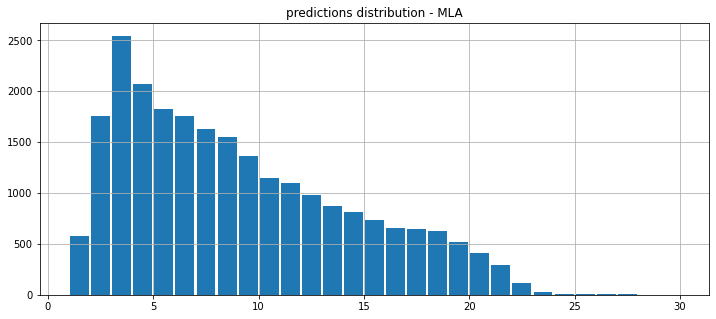

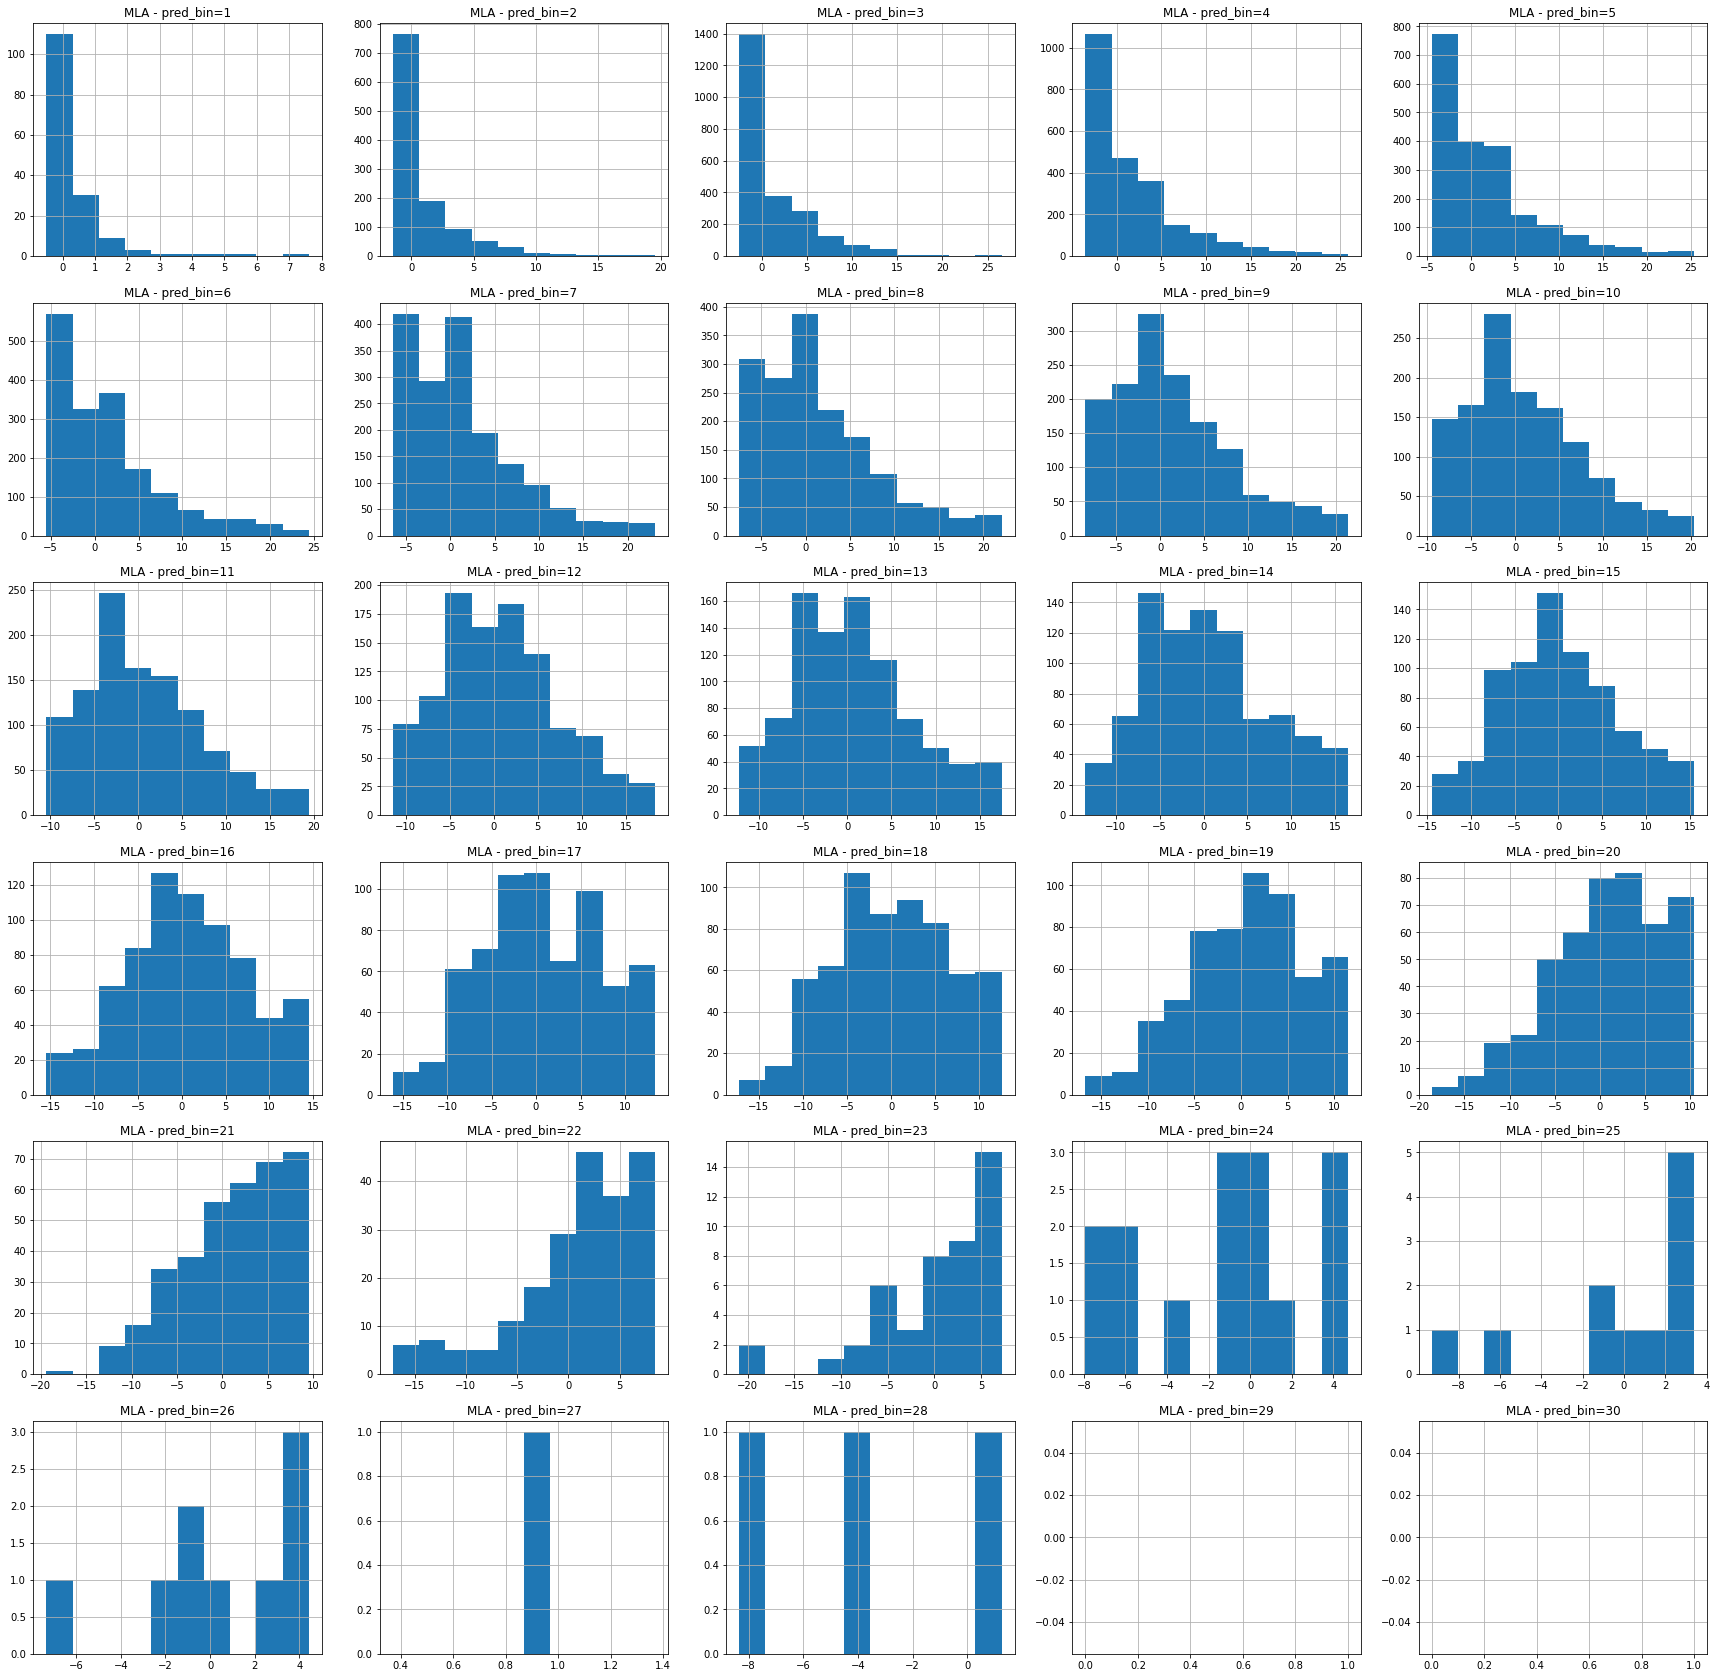

In [24]:
# results for MLA
site = "MLA"
train_fold = 0

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"target distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"predictions distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[site][train_fold].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"{site} - pred_bin={d}")
    plt.grid()
plt.show()

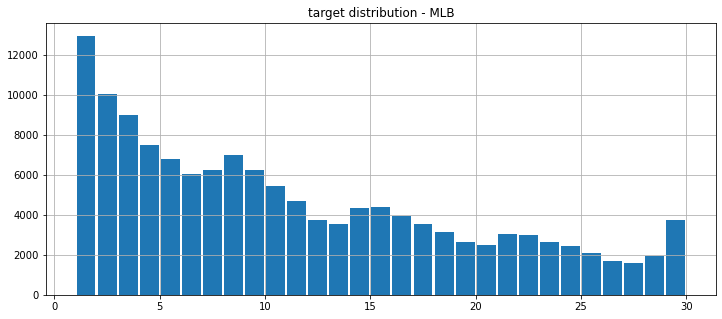

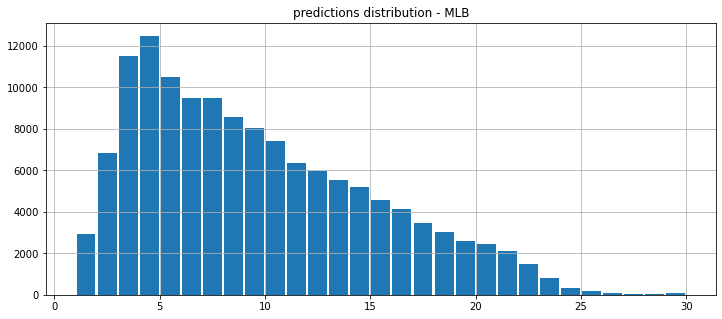

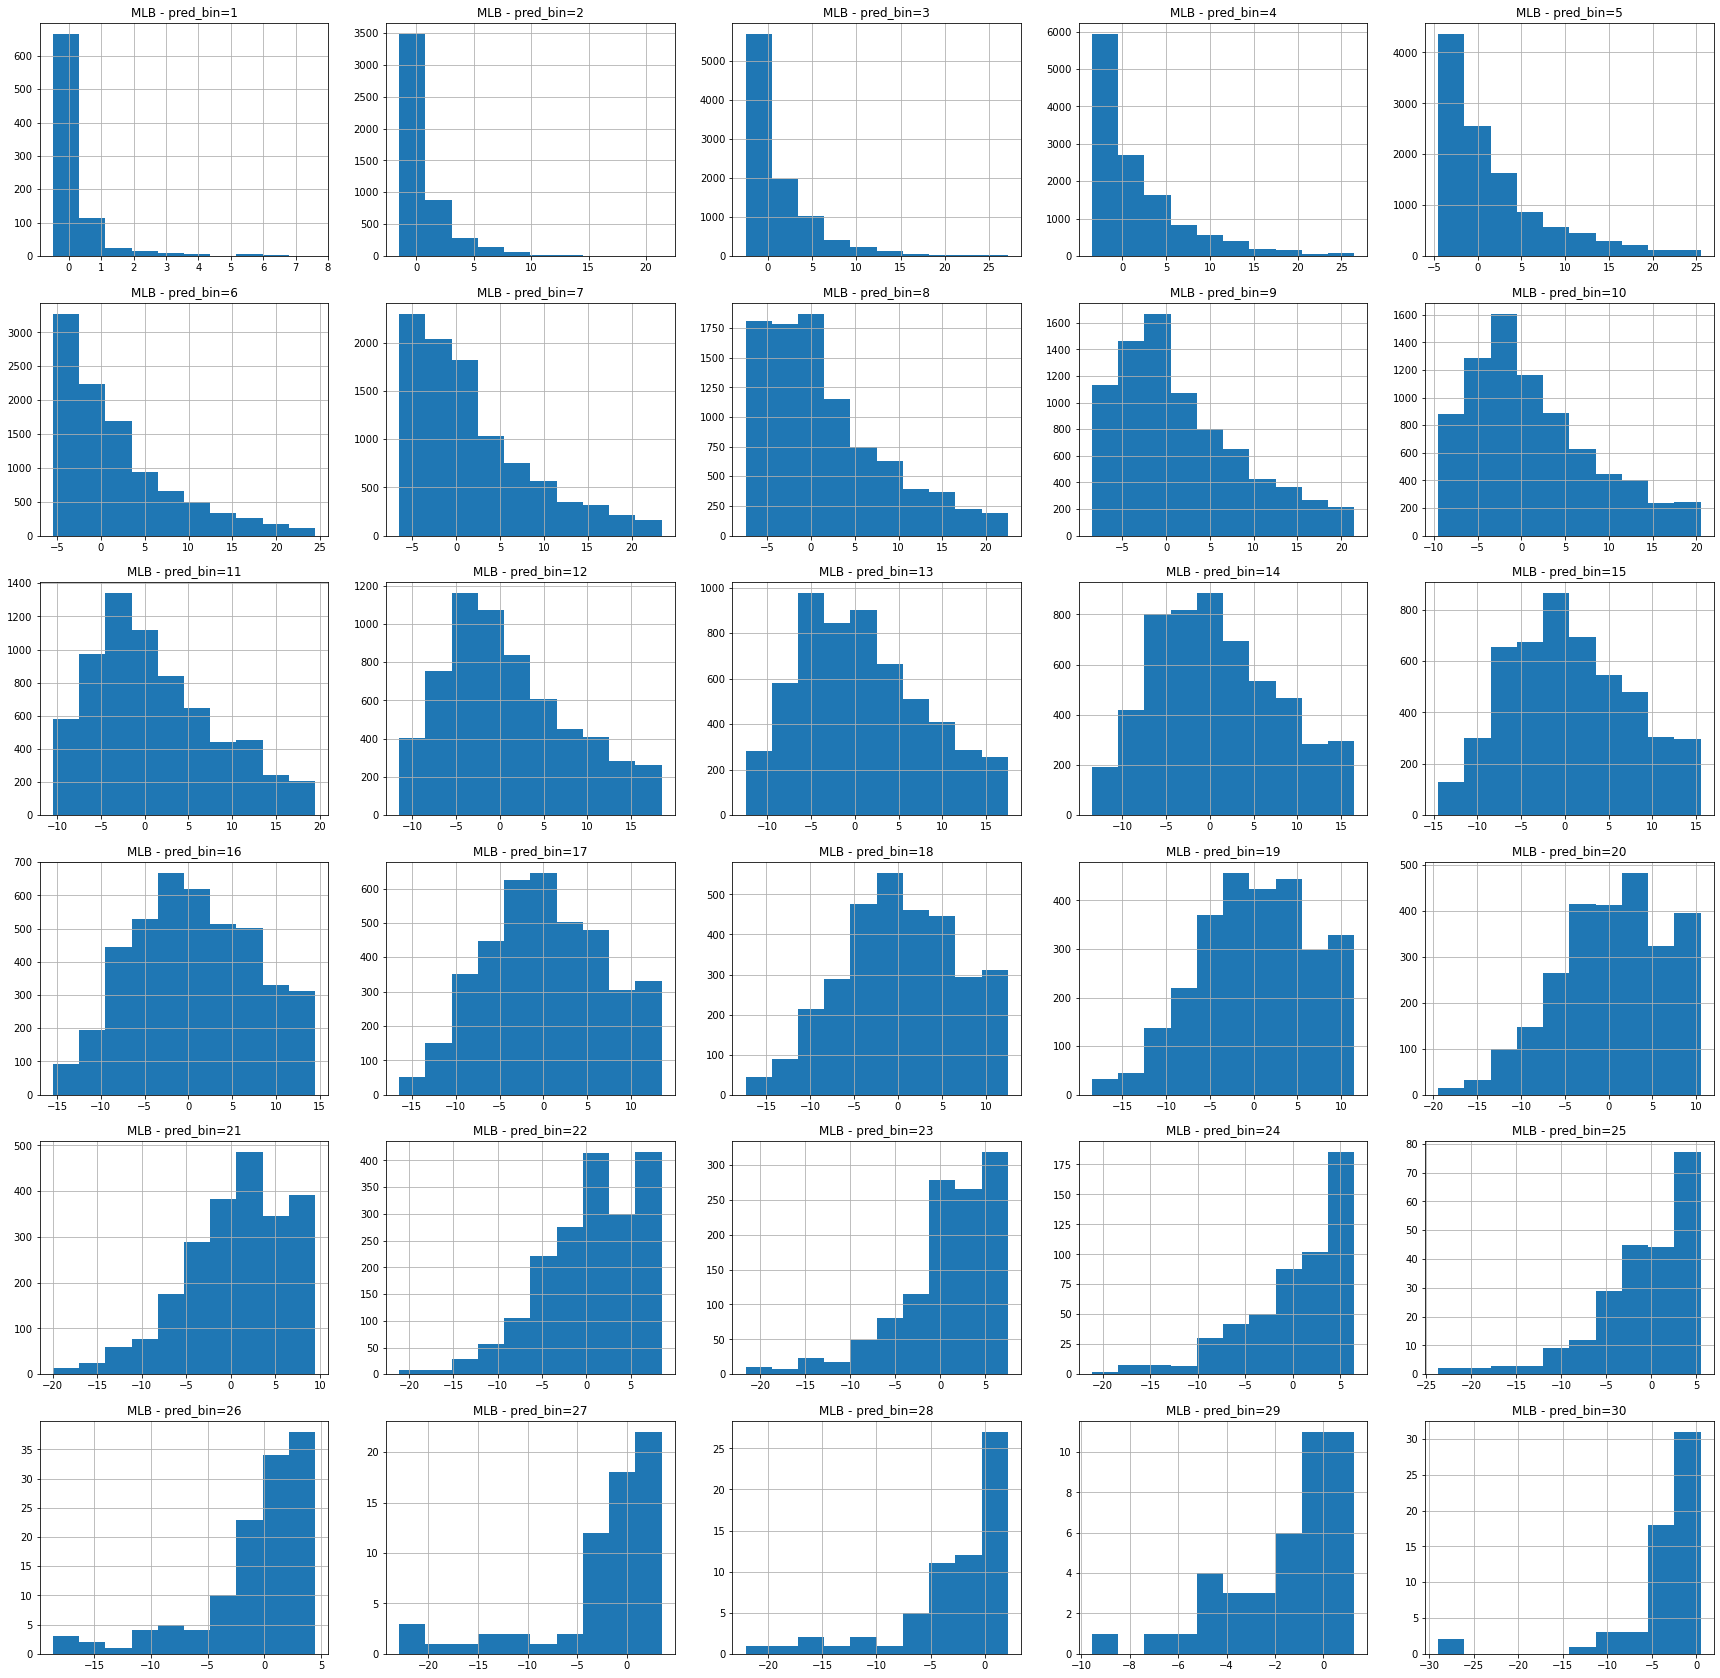

In [25]:
# results for MLB
site = "MLB"
train_fold = 0

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"target distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"predictions distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[site][train_fold].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"{site} - pred_bin={d}")
    plt.grid()
plt.show()

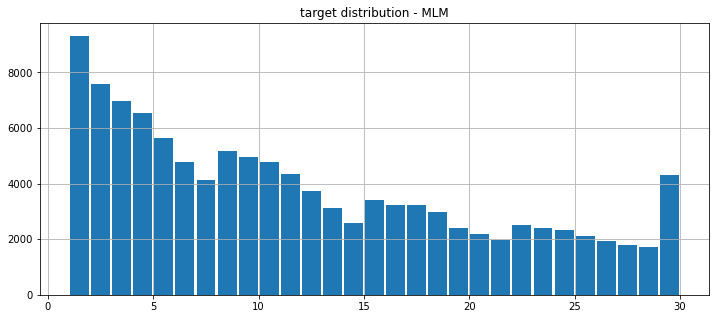

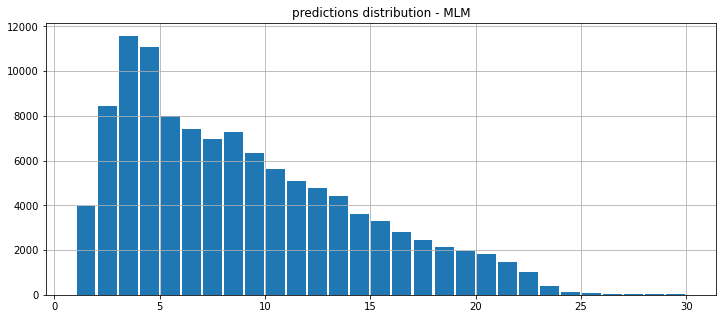

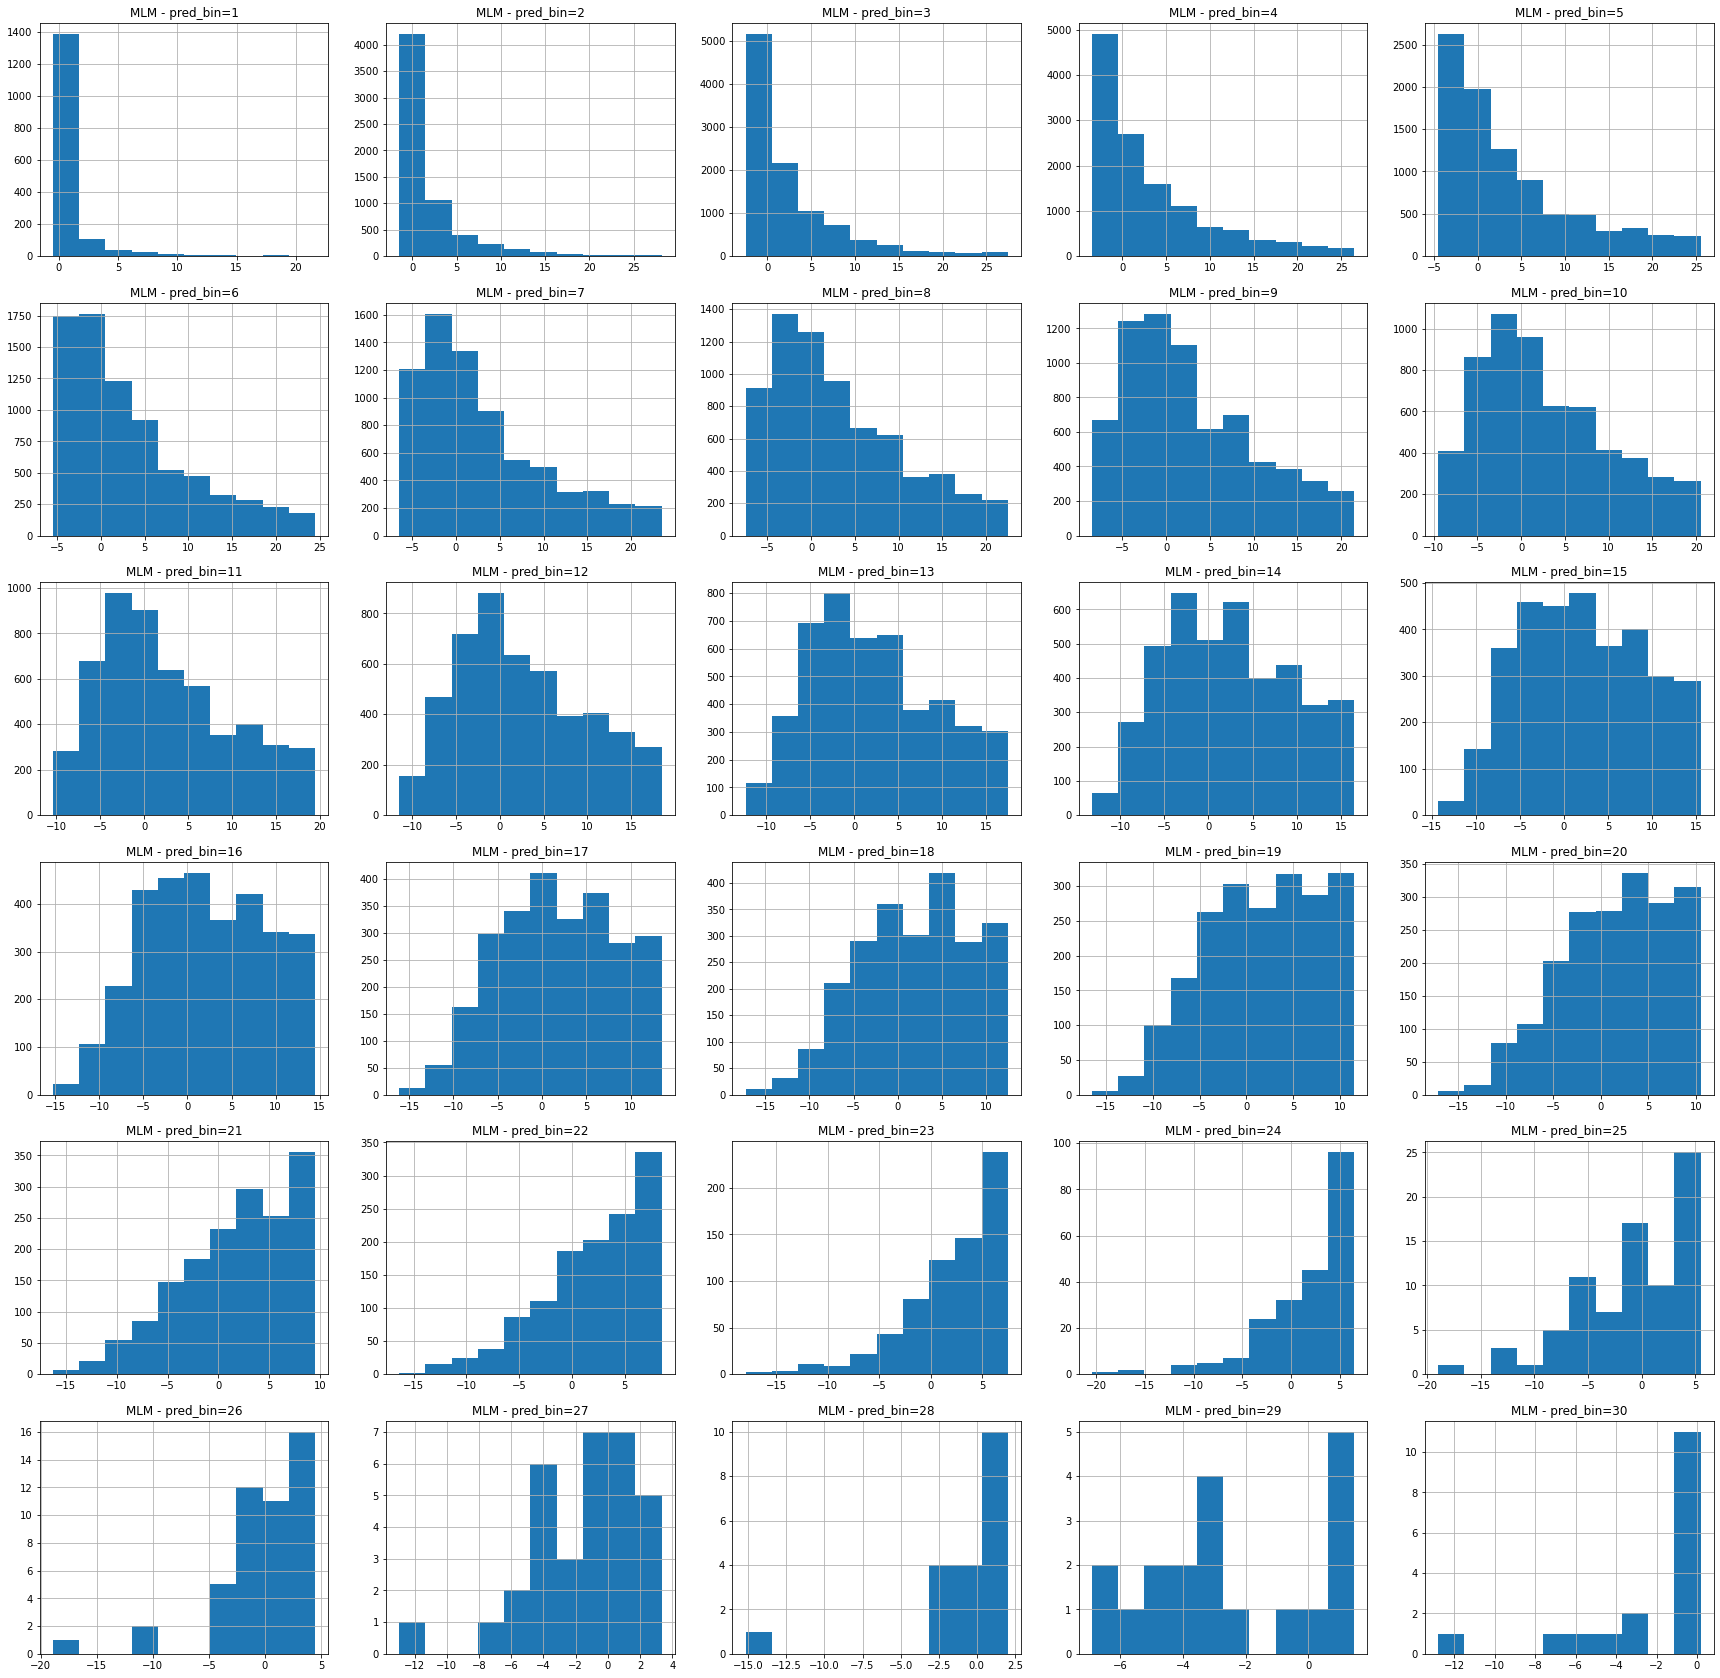

In [26]:
# results for MLM
site = "MLM"
train_fold = 1

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"target distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[site][train_fold]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title(f"predictions distribution - {site}")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[site][train_fold].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"{site} - pred_bin={d}")
    plt.grid()
plt.show()

***
## model training

***